# Imports des librairies & données

## Librairies

In [1]:
# librairies générales
import pandas as pd
import numpy as np

# librairies pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

# librairie pour centrage-réduction
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# librairies pour analyse PCA
from sklearn.decomposition import PCA

# librairies pour analyse CAH
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# librairies pour analyse KMeans
from sklearn import datasets,preprocessing, cluster, metrics, decomposition
from sklearn.cluster import KMeans

In [2]:
!pip install --upgrade kneed

Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip install pygal

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# librairie pour graphique du coude dans le cadre de K-Means
from kneed import KneeLocator

## Données

In [5]:
df = pd.read_csv("df1.csv")

In [6]:
df = df.set_index("pays")

In [7]:
df.head()

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km
pays,,,,,,,
Afghanistan,1.52,0.18,0.80,584.39,-2.76,36296113,4909
Afrique du Sud,35.70,0.59,9.02,6189.29,-0.23,57009756,8851
Albanie,16.30,0.35,13.18,4543.39,0.37,2884169,1522
Algérie,6.38,0.35,0.05,4153.00,-0.84,41389189,1354
Allemagne,19.47,0.22,10.19,43284.60,0.59,82658409,545


On constate qu'il y a des valeurs manquantes NaN pour les variables pib_hab :

In [8]:
df.describe()

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km
count,156.000000,156.000000,156.000000,153.000000,156.000000,1.560000e+02,156.000000
mean,19.600833,0.399872,9.098141,14439.457516,-0.094167,3.709732e+07,5848.237179
std,15.146308,0.204901,16.017656,19761.981380,0.913475,1.159388e+08,4007.685262
min,0.130000,0.020000,0.000000,381.410000,-3.010000,7.145800e+04,0.000000
25%,6.852500,0.230000,0.380000,1981.640000,-0.590000,3.292090e+06,2145.250000
50%,17.830000,0.380000,3.425000,5907.350000,-0.020000,9.815582e+06,5355.500000
75%,28.212500,0.532500,10.682500,17168.150000,0.650000,3.118956e+07,8769.750000
max,72.840000,0.870000,124.140000,106729.020000,1.530000,1.338677e+09,18627.000000


On crée un df comprenant uniquement les pays possédants toutes les infos pour chacune des variables

In [9]:
dff = df.dropna()

In [10]:
# on obtient un dataframe de la forme suivante :
dff.shape

(153, 7)

# Standardisation des données

In [11]:
dfs = ((dff-(dff.mean())) / dff.std())

On vérifie que les données soient bien centrées :

In [12]:
dfs.mean(axis=0)

conso_vol_hab   -6.167906e-16
ratio_vol       -3.272618e-16
imp_vol_hab      1.596399e-16
pib_hab         -6.799209e-16
pol              2.412740e-17
pop             -1.197299e-17
km              -4.571507e-17
dtype: float64

et bien réduites :

In [13]:
dfs.std(axis=0)

conso_vol_hab    1.0
ratio_vol        1.0
imp_vol_hab      1.0
pib_hab          1.0
pol              1.0
pop              1.0
km               1.0
dtype: float64

ce qui donne :

In [14]:
dfs

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km
pays,,,,,,,
Afghanistan,-1.201948,-1.073146,-0.523859,-0.701097,-3.044750,-0.008442,-0.223750
Afrique du Sud,1.047115,0.923842,-0.014420,-0.417477,-0.186171,0.168493,0.753188
Albanie,-0.229416,-0.245127,0.243397,-0.500763,0.491753,-0.293845,-1.063143
Algérie,-0.882158,-0.245127,-0.570340,-0.520518,-0.875393,0.035063,-1.104778
Allemagne,-0.020828,-0.878318,0.058091,1.459628,0.740325,0.387583,-1.305271
...,...,...,...,...,...,...,...
Ukraine,0.185786,0.388064,-0.404866,-0.607926,-2.039163,0.061530,-0.980864
Uruguay,-0.708444,-1.170560,-0.519520,0.088691,1.237470,-0.289126,1.365819
Vanuatu,-0.610401,-0.488662,0.294837,-0.587009,1.135781,-0.316043,2.575963


On peut maintenant passer à la méthode des k-moyens

# K-Means

On définit les paramètres de notre algorithme à l'aide d'un dictionnaire Python :

In [15]:
kmeans_kwargs = {"init":"random","n_init":10,"max_iter":300,"random_state":42}

On cherche ensuite à calculer le sse : la moyenne des carrées des distances entre les points et leurs centroïdes en fonction du nombre k de cluster(s).

In [16]:
sse = []
for k in range(1, 10):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfs)
    sse.append(kmeans.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [17]:
sse

[1064.0000000000002,
 836.4671416200603,
 698.623409912481,
 574.0474946500185,
 495.9399780169748,
 427.55427315965204,
 368.287735579566,
 322.74745203918127,
 293.25140428044494]

## Graphique du coude

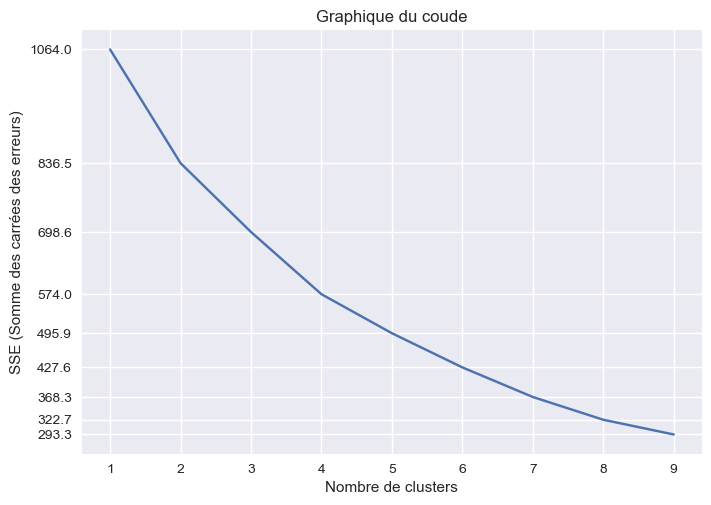

In [78]:
plt.style.use("seaborn")
plt.plot(range(1, 10), sse)

plt.title("Graphique du coude")

plt.xlabel("Nombre de clusters")
plt.xticks(range(1,10))

plt.ylabel("SSE (Somme des carrées des erreurs)")
plt.yticks(sse)

plt.show()

In [19]:
len(sse)

9

In [20]:
# situons maintenant le nombre de clusters qui permet d'avoir le SSE optimal :
kl = KneeLocator(range(1, 10), sse, curve="convex", direction="decreasing")

In [21]:
print("Selon la méthode du coude, le nombre optimal de cluster est : {}".format(kl.elbow))

Selon la méthode du coude, le nombre optimal de cluster est : 4


## Méthode de la silhouette

In [22]:
# création d'une liste des valeurs du coefficient de silhouette en fonction du nombre de cluster
coefficients_silhouette = []

# nous commençons à 2 clusters pour cette méthode
for k in range(2, 10):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfs)
    
    score = metrics.silhouette_score(dfs, kmeans.labels_)
    coefficients_silhouette.append(score)

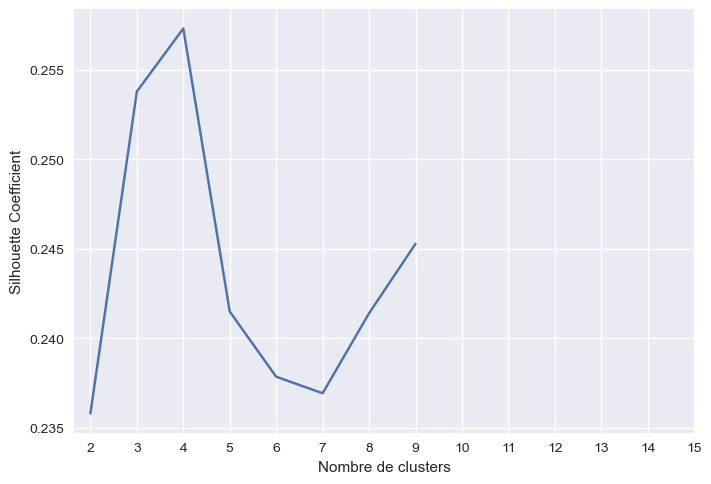

In [23]:
plt.style.use("seaborn")
plt.plot(range(2, 10), coefficients_silhouette)

plt.xticks(range(2, 16))
plt.xlabel("Nombre de clusters")

plt.ylabel("Silhouette Coefficient")
plt.show()

Le premier coefficient le plus proche de 1 est obtenu ici avec 4 clusters, ce qui confirme ce que nous avons obtenu avec la méthode du coude utilisée plus haut.

## Résultats

In [24]:
cls = cluster.KMeans(init='random', n_clusters=4, n_init=10, max_iter =300, random_state = 42)
cls.fit(dfs)

KMeans(init='random', n_clusters=4, random_state=42)

In [25]:
dfs_k = dfs.assign(cl_kmeans=cls.labels_)

In [26]:
dfs_k

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km,cl_kmeans
pays,,,,,,,,
Afghanistan,-1.201948,-1.073146,-0.523859,-0.701097,-3.044750,-0.008442,-0.223750,2
Afrique du Sud,1.047115,0.923842,-0.014420,-0.417477,-0.186171,0.168493,0.753188,0
Albanie,-0.229416,-0.245127,0.243397,-0.500763,0.491753,-0.293845,-1.063143,2
Algérie,-0.882158,-0.245127,-0.570340,-0.520518,-0.875393,0.035063,-1.104778,2
Allemagne,-0.020828,-0.878318,0.058091,1.459628,0.740325,0.387583,-1.305271,3
...,...,...,...,...,...,...,...,...
Ukraine,0.185786,0.388064,-0.404866,-0.607926,-2.039163,0.061530,-0.980864,2
Uruguay,-0.708444,-1.170560,-0.519520,0.088691,1.237470,-0.289126,1.365819,2
Vanuatu,-0.610401,-0.488662,0.294837,-0.587009,1.135781,-0.316043,2.575963,0


In [27]:
for i in range(0,4):
    print("\033[1m Groupe {}\033[0m".format(i))
    print(", ".join(dfs_k[dfs_k["cl_kmeans"]==i].index))

 Groupe 0
Afrique du Sud, Arabie saoudite, Argentine, Australie, Barbade, Belize, Bénin, Bolivie (État plurinational de), Brésil, Cabo Verde, Chili, Colombie, Congo, Costa Rica, Cuba, Dominique, El Salvador, Équateur, Fidji, Gabon, Guatemala, Guyana, Honduras, Îles Salomon, Indonésie, Iran (République islamique d'), Israël, Jamaïque, Jordanie, Kiribati, Koweït, Malaisie, Maurice, Mexique, Myanmar, Namibie, Nicaragua, Nouvelle-Zélande, Oman, Panama, Pérou, République dominicaine, Saint-Vincent-et-les Grenadines, Samoa, Sao Tomé-et-Principe, Sri Lanka, Suriname, Trinité-et-Tobago, Vanuatu
 Groupe 1
Inde
 Groupe 2
Afghanistan, Albanie, Algérie, Angola, Arménie, Azerbaïdjan, Bangladesh, Bélarus, Bosnie-Herzégovine, Botswana, Burkina Faso, Cambodge, Cameroun, Côte d'Ivoire, Djibouti, Égypte, Eswatini, Éthiopie, Fédération de Russie, Gambie, Géorgie, Ghana, Grèce, Guinée-Bissau, Haïti, Iraq, Kazakhstan, Kenya, Kirghizistan, Lesotho, Liban, Libéria, Macédoine du Nord, Madagascar, Malawi, Mali

On observe que l'on a un outlier, l'Inde, qui constitue un groupe à elle seule.<br/> Voyons ce qui se passe lorsque l'on met de côté ce outlier.

## Outlier

In [28]:
dfs_1 = dfs[dfs.index != "Inde"]

In [29]:
kmeans_kwargs = {"init":"random","n_init":10,"max_iter":300,"random_state":42}

On cherche ensuite à calculer le sse : la moyenne des carrées des distances entre les points et leurs centroïdes en fonction du nombre k de cluster(s).

In [30]:
sse1 = []
for k in range(1, 10):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfs_1)
    sse1.append(kmeans.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [31]:
sse1

[935.4753063497014,
 711.2818424923071,
 571.3143800847265,
 465.8532490553214,
 410.80204385856194,
 366.4125382462331,
 322.47577654345423,
 297.7352324320412,
 268.44945472328965]

### Graphique du coude

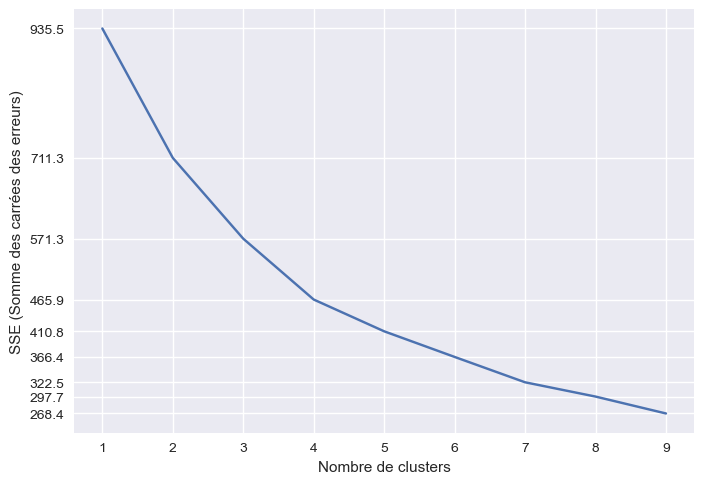

In [32]:
plt.style.use("seaborn")
plt.plot(range(1, 10), sse1)

plt.xlabel("Nombre de clusters")
plt.xticks(range(1,10))

plt.ylabel("SSE (Somme des carrées des erreurs)")
plt.yticks(sse1)

plt.show()

In [33]:
len(sse1)

9

In [34]:
# situons maintenant le nombre de clusters qui permet d'avoir le SSE optimal :
kl = KneeLocator(range(1, 10), sse1, curve="convex", direction="decreasing")

In [35]:
print("Selon la méthode du coude, le nombre optimal de cluster est : {}".format(kl.elbow))

Selon la méthode du coude, le nombre optimal de cluster est : 4


### Méthode de la silhouette

In [36]:
# création d'une liste des valeurs du coefficient de silhouette en fonction du nombre de cluster
coefficient_silhouette1 = []

# nous commençons à 2 clusters pour cette méthode
for k in range(2, 10):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfs_1)
    
    score = metrics.silhouette_score(dfs_1, kmeans.labels_)
    coefficient_silhouette1.append(score)

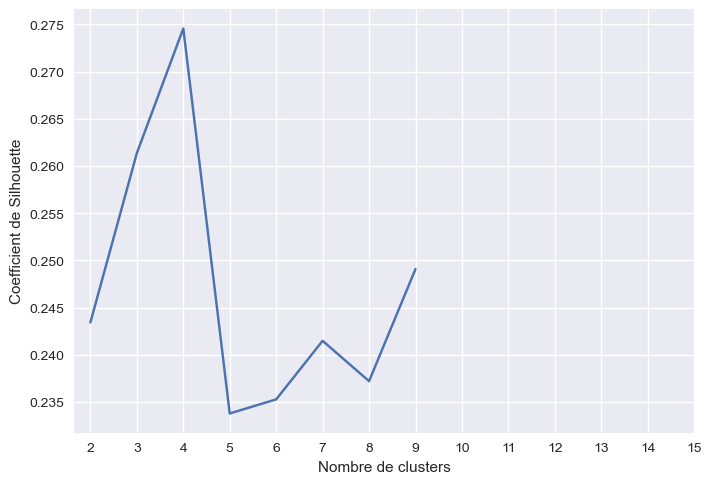

In [37]:
plt.style.use("seaborn")
plt.plot(range(2, 10), coefficient_silhouette1)

plt.xticks(range(2, 16))
plt.xlabel("Nombre de clusters")

plt.ylabel("Coefficient de Silhouette")
plt.show()

Le premier coefficient le plus proche de 1 est obtenu ici avec 4 clusters, ce qui confirme ce que nous avons obtenu avec la méthode du coude utilisée plus haut.

### Résultats

In [38]:
cls = cluster.KMeans(init='random', n_clusters=4, n_init=10, max_iter =300, random_state = 42)
cls.fit(dfs_1)

KMeans(init='random', n_clusters=4, random_state=42)

In [39]:
dfs_k1 = dfs_1.assign(cl_kmeans=cls.labels_)

In [40]:
dfs_k1

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km,cl_kmeans
pays,,,,,,,,
Afghanistan,-1.201948,-1.073146,-0.523859,-0.701097,-3.044750,-0.008442,-0.223750,1
Afrique du Sud,1.047115,0.923842,-0.014420,-0.417477,-0.186171,0.168493,0.753188,0
Albanie,-0.229416,-0.245127,0.243397,-0.500763,0.491753,-0.293845,-1.063143,1
Algérie,-0.882158,-0.245127,-0.570340,-0.520518,-0.875393,0.035063,-1.104778,1
Allemagne,-0.020828,-0.878318,0.058091,1.459628,0.740325,0.387583,-1.305271,3
...,...,...,...,...,...,...,...,...
Ukraine,0.185786,0.388064,-0.404866,-0.607926,-2.039163,0.061530,-0.980864,1
Uruguay,-0.708444,-1.170560,-0.519520,0.088691,1.237470,-0.289126,1.365819,1
Vanuatu,-0.610401,-0.488662,0.294837,-0.587009,1.135781,-0.316043,2.575963,0


In [41]:
for i in range(0,4):
    print("\033[1m Groupe {}\033[0m".format(i))
    print(", ".join(dfs_k1[dfs_k1["cl_kmeans"]==i].index))

 Groupe 0
Afrique du Sud, Arabie saoudite, Argentine, Australie, Barbade, Belize, Bénin, Bolivie (État plurinational de), Brésil, Cabo Verde, Chili, Colombie, Congo, Costa Rica, Cuba, El Salvador, Équateur, Fidji, Gabon, Guatemala, Guyana, Honduras, Îles Salomon, Indonésie, Iran (République islamique d'), Israël, Jamaïque, Jordanie, Kiribati, Koweït, Libéria, Macédoine du Nord, Malaisie, Maroc, Maurice, Mexique, Myanmar, Namibie, Nicaragua, Nouvelle-Zélande, Oman, Panama, Pérou, République dominicaine, Sao Tomé-et-Principe, Sri Lanka, Suriname, Trinité-et-Tobago, Vanuatu
 Groupe 1
Afghanistan, Albanie, Algérie, Angola, Arménie, Azerbaïdjan, Bangladesh, Bosnie-Herzégovine, Botswana, Burkina Faso, Cambodge, Cameroun, Côte d'Ivoire, Djibouti, Égypte, Eswatini, Éthiopie, Fédération de Russie, Gambie, Géorgie, Ghana, Guinée-Bissau, Haïti, Iraq, Kazakhstan, Kenya, Kirghizistan, Lesotho, Liban, Madagascar, Malawi, Mali, Mauritanie, Mongolie, Monténégro, Népal, Niger, Nigéria, Pakistan, Paragu

On peut analyser les caractéristiques des groupes en calculant leurs caractéristiques moyennes, autrement dit les centroides de chaque groupe :

In [44]:
centroids_kmeans1 =  dfs_k1.groupby("cl_kmeans").mean()

In [45]:
centroids_kmeans1

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km
cl_kmeans,,,,,,,
0,0.581220,0.949686,-0.044561,-0.242337,0.096759,-0.101652,0.684656
1,-0.785378,-0.571150,-0.387832,-0.554854,-0.687871,-0.036150,-0.099244
2,2.360757,1.138153,4.319274,0.367891,1.110924,-0.289148,0.816335
3,0.265733,-0.492721,0.144615,1.251901,0.927696,-0.068012,-0.883048


<AxesSubplot:ylabel='cl_kmeans'>

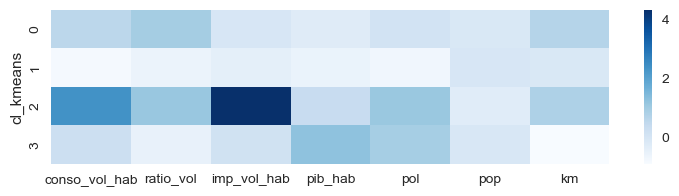

In [84]:
plt.figure(figsize=(9,2))
heatmap(centroids_kmeans1,cmap="Blues")

**Analyse des résultats :**

Le **groupe 0** comprend les pays très éloignés,  dont la viande de volaille constitue une part non négligeable de la conso. générale de viande, mais dont le niveau de conso de viande reste malgré tout faible. Iils importent donc peu de volailles en comparaison avec d'autres groupes de pays. La stabilité politique est relativementayant une croissance du PIB faible, une disponibilité en protéines faible par habitant, une stabilité politique faible, de faible imports de volailles, et une population importante.

Le **groupe 1** comprend les pays les plus consommateurs de volailles, qui en importent beaucoup et on une grande population. En revanche ces pays ont une stabilité politique moyenne et un PIB/hab faible.

Le **groupe 2** est le plus intéressant, il comprend les pays ayant une croissance du PIB faible, une disponibilité en protéines élevée par habitant, une très bonne stabilité politique, de larges imports de volailles, et une population peu importante.

Le **groupe 3** est le plus intéressant, il comprend les pays ayant une croissance du PIB faible, une disponibilité en protéines élevée par habitant, une très bonne stabilité politique, de larges imports de volailles, et une population peu importante.

Ce dernier groupe est donc celui sur lequel se focaliser pour nos futurs exports.

# CAH
Classification Ascendante Hierarchique

In [48]:
Z = linkage(dfs_1,method='ward',metric='euclidean')

In [49]:
groupes = fcluster(Z,t=13,criterion='distance')

In [50]:
np.unique(groupes).size
# avec une distance euclidienne t=13, on a 4 groupes distincts de pays :

4

In [51]:
dfs_cah = dfs_1.assign(cl_cah=groupes)

In [52]:
dfs_cah

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km,cl_cah
pays,,,,,,,,
Afghanistan,-1.201948,-1.073146,-0.523859,-0.701097,-3.044750,-0.008442,-0.223750,1
Afrique du Sud,1.047115,0.923842,-0.014420,-0.417477,-0.186171,0.168493,0.753188,4
Albanie,-0.229416,-0.245127,0.243397,-0.500763,0.491753,-0.293845,-1.063143,2
Algérie,-0.882158,-0.245127,-0.570340,-0.520518,-0.875393,0.035063,-1.104778,1
Allemagne,-0.020828,-0.878318,0.058091,1.459628,0.740325,0.387583,-1.305271,2
...,...,...,...,...,...,...,...,...
Ukraine,0.185786,0.388064,-0.404866,-0.607926,-2.039163,0.061530,-0.980864,1
Uruguay,-0.708444,-1.170560,-0.519520,0.088691,1.237470,-0.289126,1.365819,4
Vanuatu,-0.610401,-0.488662,0.294837,-0.587009,1.135781,-0.316043,2.575963,4


In [53]:
# regardons par exemple à quels groupes appartient la France :
dfs_cah[dfs_cah.index == "France"]

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km,cl_cah
pays,,,,,,,,
France,0.204868,-0.586076,-0.09003,1.234318,0.107596,0.2354,-1.440337,2


In [54]:
dfs_k[dfs_k.index== "France"]

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km,cl_kmeans
pays,,,,,,,,
France,0.204868,-0.586076,-0.09003,1.234318,0.107596,0.2354,-1.440337,3


In [55]:
# Pour visualiser quelles sont les caractéristiques de chaque groupe, faisons la moyenne des variables pour chaque groupe.
# De cette façon on obtiendra nos "centroides"

centroids_cah = dfs_cah.groupby(["cl_cah"]).mean()

In [56]:
centroids_cah

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km
cl_cah,,,,,,,
1,-0.681437,-0.119062,-0.375774,-0.587926,-0.768388,-0.021262,-0.026701
2,0.140367,-0.455031,0.221795,0.904863,0.836634,-0.192195,-0.892915
3,2.929230,1.086198,5.481768,0.227854,1.124482,-0.296809,1.299731
4,0.841311,0.590386,0.009369,0.049322,0.379056,-0.018155,0.900150


In [58]:
# comparons :
centroids_kmeans1

,conso_vol_hab,ratio_vol,imp_vol_hab,pib_hab,pol,pop,km
cl_kmeans,,,,,,,
0,0.581220,0.949686,-0.044561,-0.242337,0.096759,-0.101652,0.684656
1,-0.785378,-0.571150,-0.387832,-0.554854,-0.687871,-0.036150,-0.099244
2,2.360757,1.138153,4.319274,0.367891,1.110924,-0.289148,0.816335
3,0.265733,-0.492721,0.144615,1.251901,0.927696,-0.068012,-0.883048


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 1, 'conso_vol_hab'),
  Text(1.5, 1, 'ratio_vol'),
  Text(2.5, 1, 'imp_vol_hab'),
  Text(3.5, 1, 'pib_hab'),
  Text(4.5, 1, 'pol'),
  Text(5.5, 1, 'pop'),
  Text(6.5, 1, 'km')])

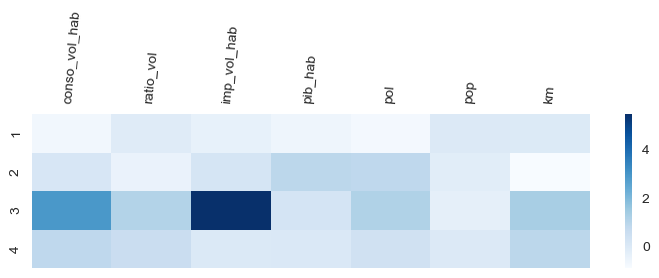

In [83]:
plt.figure(figsize=(9,2))
ax = heatmap(centroids_cah,cmap="Blues")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=85)


## Dendrogramme

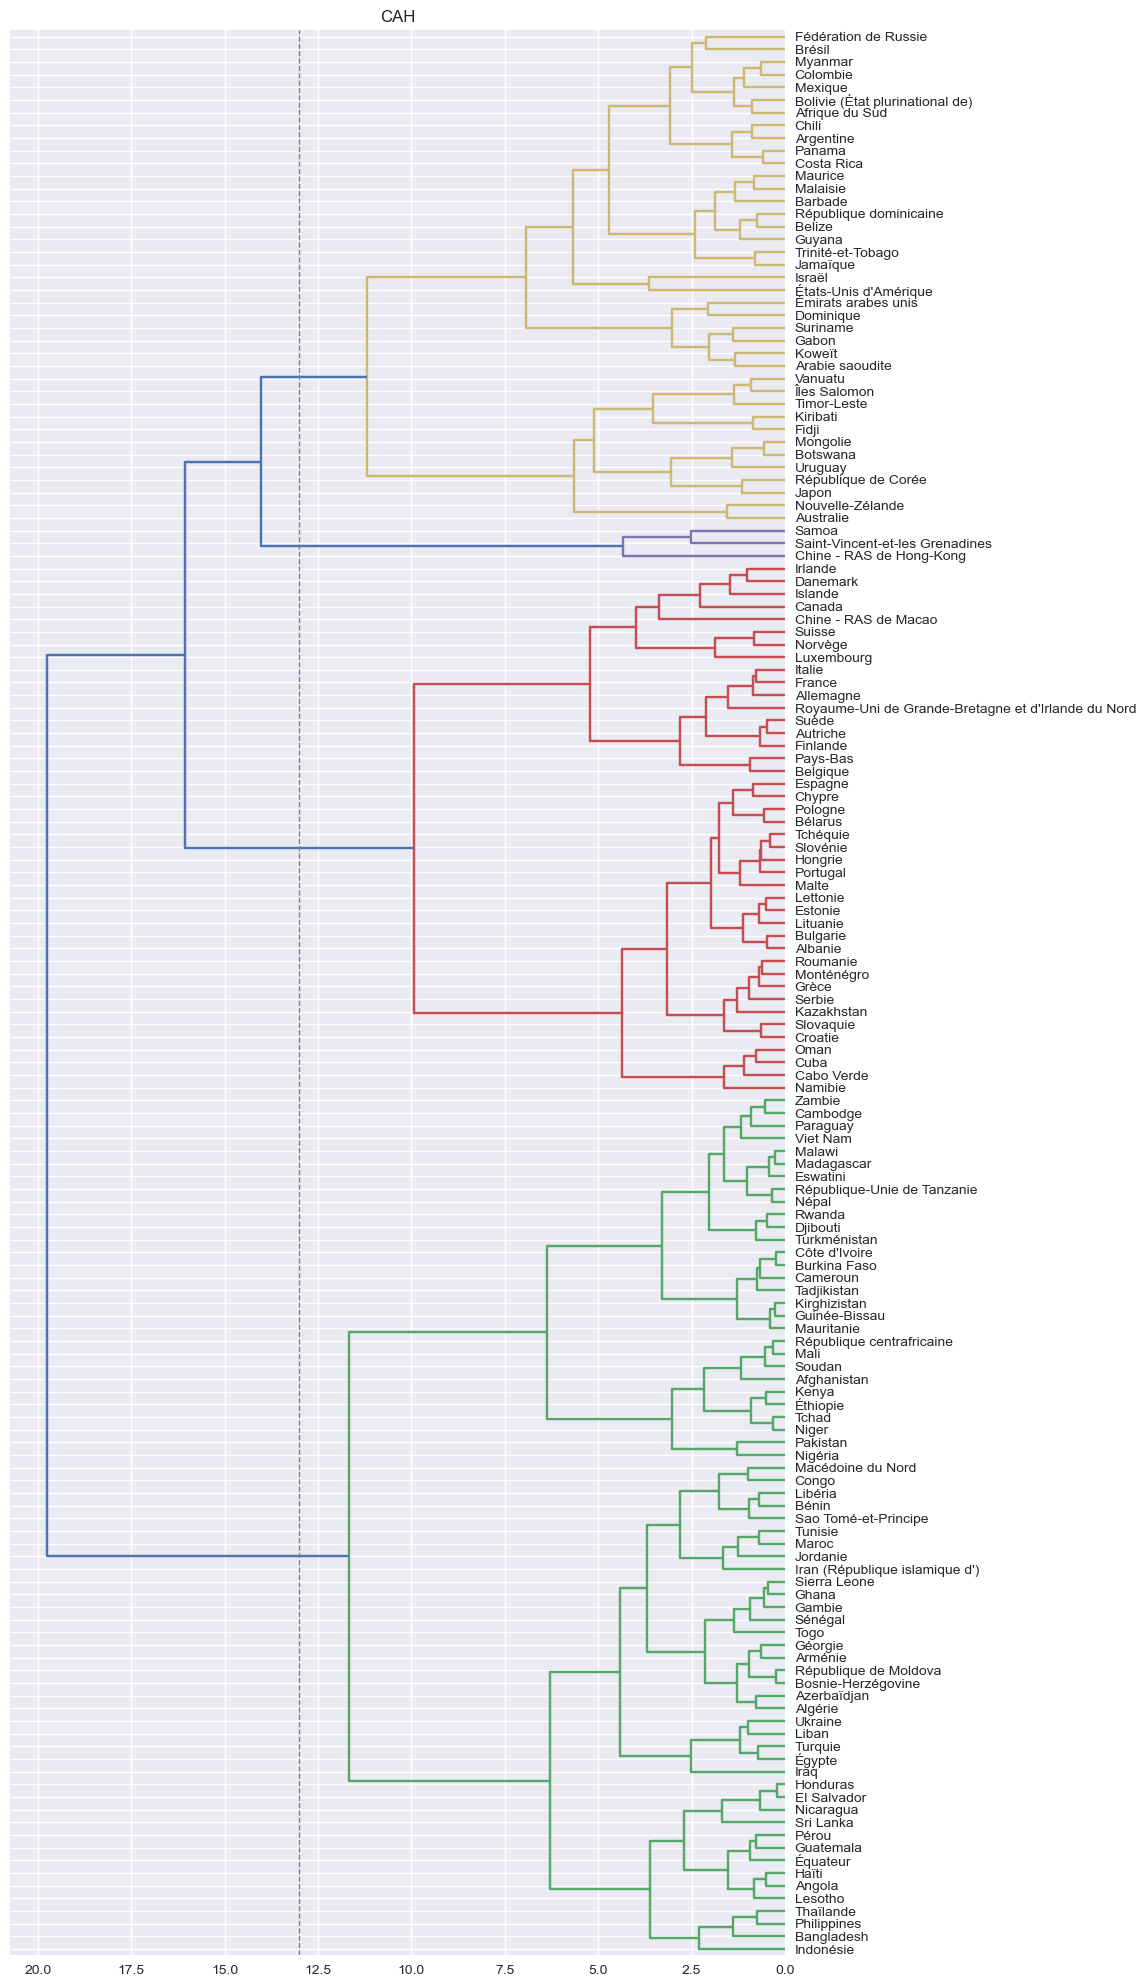

In [60]:
plt.figure(figsize=(10,25))
plt.title("CAH")
dendrogram(Z,labels=dfs_cah.index,orientation='left',leaf_font_size=10)

# création ligne matplotlib
plt.axvline(x=13,color="grey", lw=1, linestyle='dashed')
plt.show()

# ACP

In [61]:
# on instancie notre classe PCA
pca = decomposition.PCA(svd_solver='full')

In [62]:
# on scale notre objet pca :
pca.fit(dfs_1)

PCA(svd_solver='full')

In [63]:
pca.transform(dfs_1)

array([[-2.97480879, -0.32556982, -0.83589821, ...,  1.48329007,
         0.22363113, -0.60814632],
       [ 0.67703534, -1.41244304, -0.10464035, ...,  0.22750086,
        -0.33862984,  0.04859418],
       [-0.14565149,  0.60783569, -0.48041482, ..., -0.89387513,
        -0.31594536,  0.15861241],
       ...,
       [ 0.14758277, -0.92472198,  2.80240942, ..., -0.24810798,
         0.15034973,  0.01358779],
       [-0.87367096, -0.22725353,  1.46575214, ...,  0.34665372,
        -0.44011278,  0.45396609],
       [-1.20074031,  0.01813551,  1.01952393, ..., -0.42824227,
         0.04233397,  0.0754006 ]])

In [64]:
pca.transform(dfs_1).shape

(152, 7)

In [65]:
# on obtient le nombre suivant de composantes principales :
pca.n_components_

7

In [66]:
print("Les composantes principales expliquent respectivement {} % de l'inertie.".format(pca.explained_variance_ratio_))


Les composantes principales expliquent respectivement [0.37797734 0.24435024 0.14388688 0.11040789 0.06733648 0.03601579
 0.02002539] % de l'inertie.


In [67]:
# Les coordonnées de ces composantes, sont les suivantes (dans un espace à 4 dimensions) :
coord = pca.components_
display(coord)

array([[ 0.55940421,  0.32753607,  0.45725521,  0.38282814,  0.46416001,
        -0.04584177,  0.08124869],
       [-0.20154383, -0.55678336, -0.01823836,  0.53838545,  0.29692281,
        -0.03731599, -0.51925447],
       [-0.22544875, -0.37899892, -0.06397966,  0.02142314,  0.44470351,
        -0.04094644,  0.77559172],
       [-0.19342127, -0.29030089,  0.84904589, -0.3524447 , -0.1098469 ,
        -0.13143217, -0.06226284],
       [ 0.24641592, -0.29449421,  0.14426666,  0.45793373, -0.62587272,
         0.37022197,  0.30537715],
       [-0.67764642,  0.5054641 ,  0.1841836 ,  0.45704651, -0.12994602,
        -0.10397948,  0.12160819],
       [-0.19565942,  0.11214643,  0.10428924, -0.14252258,  0.27921702,
         0.91086716, -0.10154072]])

In [68]:
coord.shape

(7, 7)

## Eboulis des valeurs propres

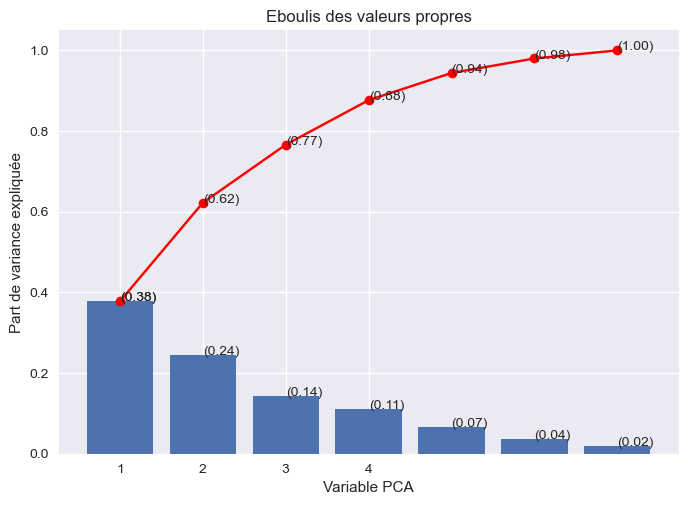

In [69]:
PC_values = np.arange(1,pca.n_components_+ 1,1) 
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.xticks(np.arange(1,5))
plt.xlabel("Variable PCA")
plt.ylabel("Part de variance expliquée")
plt.title("Eboulis des valeurs propres")
plt.plot(PC_values,pca.explained_variance_ratio_.cumsum(),"o-",color="red")

for i, j in zip(PC_values, pca.explained_variance_ratio_):
    plt.text(i,j, f"({j:.2f})")

for i, j in zip(PC_values, pca.explained_variance_ratio_.cumsum()):
    plt.text(i,j, f"({j:.2f})")
    
# on a 88% de la variance expliquée par les 4 premières variables :

## Cercle des corrélations

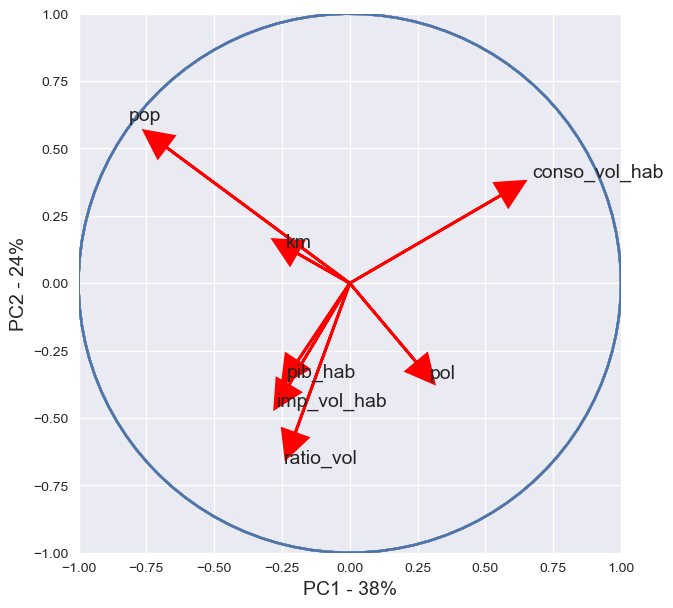

In [70]:
# Cercle des corrélations pour les composantes 1 et 2 :
fig, ax = plt.subplots(figsize=(7,7))
for i, (comp, var) in enumerate(zip(pca.components_, dfs.columns)):
    x = comp[0]
    y = comp[1]
    
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, linewidth=2, color='red')
    ax.text(x* 1.2, y * 1.2, var, fontsize=14)
    ax.set_xlabel("PC1 - 38%", fontsize=14)
    ax.set_ylabel("PC2 - 24%", fontsize=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.grid(True)
    
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))

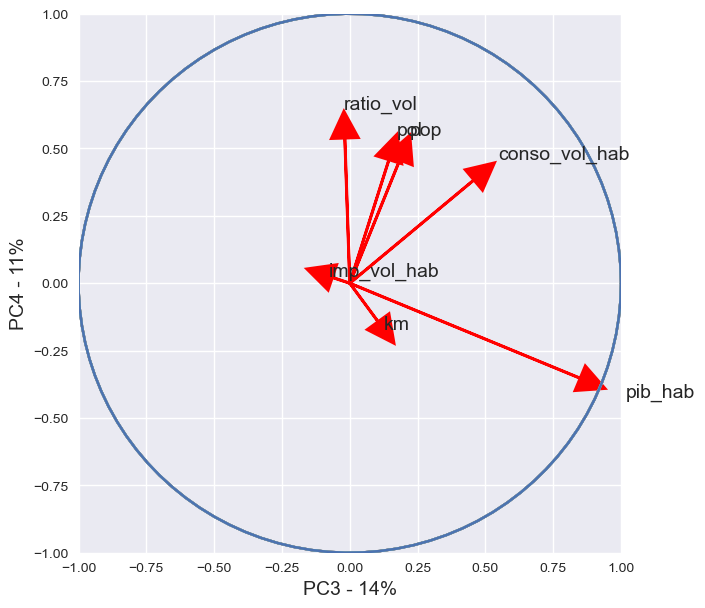

In [71]:
# Cercle des corrélations pour les composantes 3 et 4 :
fig, ax = plt.subplots(figsize=(7,7))
for i, (comp, var) in enumerate(zip(pca.components_, dfs.columns)):
    x = comp[2]
    y = comp[3]
    
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, linewidth=2, color='red')
    ax.text(x* 1.2, y * 1.2, var, fontsize=14)
    ax.set_xlabel("PC3 - 14%", fontsize=14)
    ax.set_ylabel("PC4 - 11%", fontsize=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.grid(True)
    
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))

## Projection des individus sur le plan factoriel

In [72]:
X_proj = pca.transform(dfs_1)

In [73]:
x_y = (0,1)

In [74]:
X_proj[:5]

array([[-2.97480879, -0.32556982, -0.83589821,  0.68481807,  1.48329007,
         0.22363113, -0.60814632],
       [ 0.67703534, -1.41244304, -0.10464035, -0.39543807,  0.22750086,
        -0.33862984,  0.04859418],
       [-0.14565149,  0.60783569, -0.48041482,  0.53846392, -0.89387513,
        -0.31594536,  0.15861241],
       [-1.54348148,  0.34700605, -0.93534993,  0.09031998, -0.21644821,
         0.10586916,  0.12636747],
       [ 0.49386764,  2.15127675, -0.33876184, -0.26811938,  0.23775568,
        -0.04809037,  0.46274621]])

In [75]:
def display_factorial_planes(   X_proj, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_proj)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



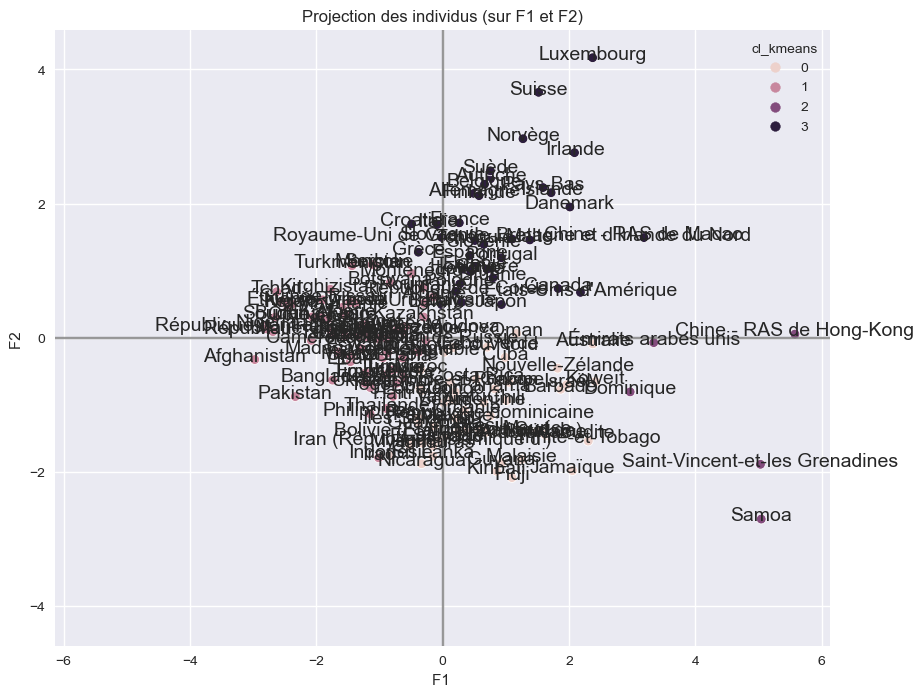

In [76]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, labels = dfs_k1.index, clusters=dfs_k1['cl_kmeans'])

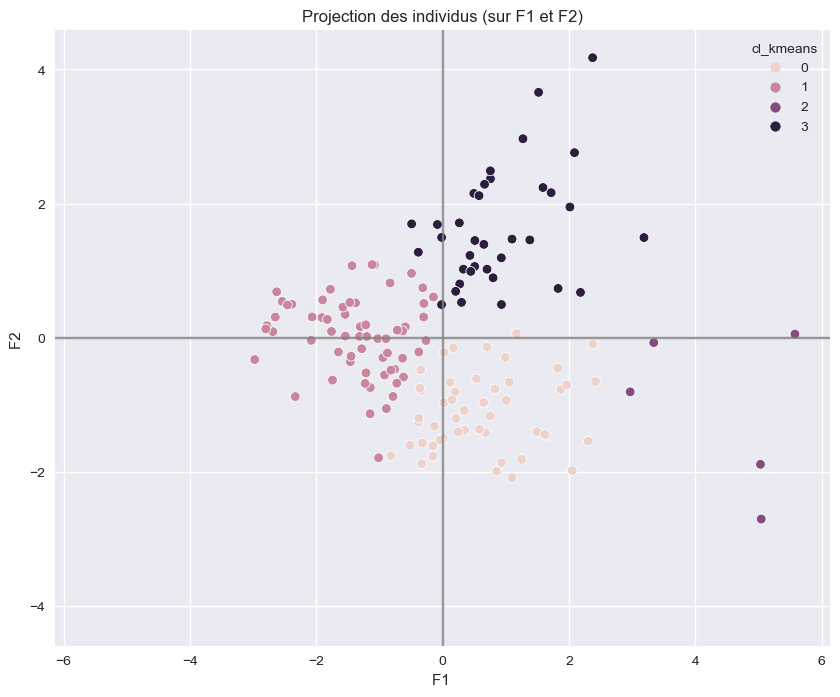

In [77]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=dfs_k1['cl_kmeans'])